# Пишем свой фреймворк

In [45]:
# только numpy, только хардкор
import numpy as np

Мотивация: конечным пользователям вашего фреймворка не хочется думать, как они работают слои внутри. Им просто хочется объявить последовательность элементарных операций над входными данными, а о градиентах и прочем матане пусть позаботится сам фреймворк.

**Module** — это абстрактный класс, от которого будут наследоваться слои нашей нейронной сети. Абстрактные классы нужны, чтобы можно было реализовывать не все методы, а только переопределить некоторые. Все в лучших традициях ООП.

Модуль — это такая чёрная коробка, которая
1. Умеет принимать какие-то входные данные $X$ и возращать какие-то выходные данные $Y$ (`forward`)
2. Возможно, имеет какие-то параметры, которые можно изменять, (`parameters`, `grad_parameters`)
3. Будучи встроенной в вычислительный граф, умеет по градиенту относительно своих выходных значений вычислять градиент относительно входных данных, а также собственных параметров (`backward`)
4. Умеет переключаться в режимы обучения и инференса, если они отличаются (`train`, `eval`)

Теперь поподробнее.

## Входные данные

Современные нейросети оптимизируют различными вариантами стохастического градиентного спуска, и мы тоже будем его использовать. Его отличие от обычного в том, что на каждом шаге мы не считаем градиент на всем датасете (это было бы слишком долго), а оцениваем его, усреднив градиенты на его случайно выбранной малой части, которую называют батчем (`batch`). Если батч формировать случайно, и если его размер достаточно большой, то мы можем быстро получить немного шумную, но приемлемую для нас оценку градиента, и не прогонять через сеть все миллионы примеров ради одного маленького шага. Эта интуиция ограничивает размер батча сверху.

Математик бы принял время прогона одного примера по всей сети за константу и пришел бы к выводу, что нужно считать по одному примеру и делать каждый раз один шаг, но маленький. Это верное заключение, но в реальности, если увеличить размер батча в $k$ раз, то он будет работать не в $k$ раз дольше, а намного меньше.

Самая долгая операция в большинстве нейросетей — это перемножение матриц. Начиная с каких-то размеров для их перемножения имеет использовать алгоритм Штрассена, который работает уже быстрее, чем линейно. Проведём небольшой вычислительный эксперимент:

In [3]:
A = np.random.randn(256, 2000)
B = np.random.randn(2000, 800)

# помножить каждый вектор-строку на B и сконкатенировать
%time C = np.stack(np.dot(A[i].T, B) for i in range(256))

# это то же самое, что использовать одно-большое матричное умножение
%time C = np.dot(A, B)

Wall time: 257 ms
Wall time: 23 ms


Такая чисто вычислительная причина ограничивает размер батча снизу. На практике, в большинстве случаев оптимальный размер батча — несколько сотен. В случае с CPU это несколько десятков, потому что выгода от распараллеливания вычислений не такая сильная.

Вообще, почти все наши слои будут работать с векторами независимо, но из-за вычилсительных причин мы будем объединять их в матрицы. Вообще, более сложные нейросети работают с тензорами. «Тензор» это, вообще говоря, сложный математический объект, но в DL этот термин используется просто в занчении «многомерный массив». Например, картинки — это четырехмерный тензор: `[batch, channel, x, y]`.

### Forward

Эта функция просто принимает тензор (`numpy.ndarray`) и возвращает какой-то другой, над которым применили соответствующие операции.

Важный нюанс: нам позже для реализации `backward` почти всегда будет нужно сохранять где-нибудь выход `forward` (это создает очень большую нагрузку на память при обучении; [в принципе это можно и не делать](https://arxiv.org/pdf/1604.06174.pdf), но так проще). Условимся сохранять его в `self.output`, сразу после того, как посчитали.

### Параметры

Параметр модели — это что-то, что можно поодгонять, чтобы функция потерь стала меньше. Он должен быть доступен оптимизатору, а оптимизатору не обязательно знать, как всё у слоя все внутри работает. Ему нужны просто градиенты — насколько ему нужно подвинуть параметры сети, чтобы стало лучше.

Общаться с ним мы будем посредством двух функций: `params` и `grad_params`. Обе возвращают списки из тензоров — значения параметров и их посчитанных градиентов (см. `backward`) соответственно. Питон делает shallow copy, поэтому у оптимизатора так есть доступ на их изменение.

### Backward

После того, как мы в вычислительном графе все последовательно посчитали и дошли до функции потерь, нам надо подогнать параметры так, чтобы на тех же данных при повторном прогоне она стала меньше — иными словами, нам надо сделать шаг против градиента функции потерь относительно параметров сети.

Посчитать эти градиенты — нетривиальная задача. Мы могли бы рассмотреть каждый параметр по отдельности и как-нибудь посчитать градиент для него. Но это очень долго — параметров в современных сетях бывает по несколько миллионов.

Вместо этого мы применим трюк, основанный на формуле для производной сложной функции:

$$ f(g(x))' = f'(g(x)) \cdot g'(x) $$

Представьте, что часть сети от параметра до выхода — это всего две последовательно выполненные функции: $g$ и $f$. Тогда, согласно формуле, нам для этого параметра достаточно посчитать и перемножить две величины — $g'(x)$ (производная текущего слоя) и f'(g(x)) (производная относительно выхода текущего слоя).

Какие-то другие параметры могли тоже зависеть от производной относительно выхода.  и мы получаем выигрыш за счет того, что считаем её только один раз и запоминаем. Можно сказать, что мы применяем таким образом динамическое программирование на вычислительном графе, чтобы посчитать градиенты относительно всех его параметров.

Обратный прогон (`backward`) определяется для каждого слоя и нужен как раз для подсчета градиентов, имея градиент относительно своих выходных значений (аналог $f'(g(x)))$.

Он должен делать две вещи:

1. Посчитать градиент относительно собственных параметров.
2. Посчитать и вернуть градиент относительно своих входных данных.

Для лучшего понимания рассмотрите пример с `Linear` и `ReLU`.

### train / eval

Некоторые слои ведут себя по-разному во время обучечния и предсказания (`inference`). Обычно, это связано с разного вида регуляризацией — например, так ведут себя `BatchNorm` и `Dropout`.

По сути, для таких слоев нужно просто написать два разных `forward`-а для обучения и инференса.

In [46]:
class Module():
    def __init__(self):
        self._train = True
    
    def forward(self, input):
        raise NotImplementedError

    def backward(self,input, grad_output):
        raise NotImplementedError
    
    def parameters(self):
        'Возвращает список собственных параметров.'
        return []
    
    def grad_parameters(self):
        'Возвращает список тензоров-градиентов для своих параметров.'
        return []
    
    def train(self):
        self._train = True
    
    def eval(self):
        self._train = False

Это **абстрактный класс** — от него наследуются другие слои, в которых эти функции будут реализованы.

# Sequential

**Sequential** будет оборачивать список модулей и выполнять их последовательно.

Это своего рода контейнер, внутри которого есть какой-то пайплайн.

Можно даже засовывать один Sequential внутри другого.

Многие не знают, но в питоне почти всегда для итерирования используется не **deep copy**, а **shallow copy**. Это делается для экономии памяти.

In [3]:
class Sequential(Module):
    def __init__ (self, *layers):
        super().__init__()
        self.layers = layers

    def forward(self, input):
        """
        Прогоните данные последовательно по всем слоям:
        
            y[0] = layers[0].forward(input)
            y[1] = layers[1].forward(y_0)
            ...
            output = module[n-1].forward(y[n-2])   
            
        Это должен быть просто небольшой цикл: for layer in layers...
        
        Хранить выводы ещё раз не надо: они сохраняются внутри слоев после forward.
        """

        for layer in self.layers:
            input = layer.forward(input)

        self.output = input
        return self.output

    def backward(self, input, grad_output):
        """
        Backward -- это как forward, только наоборот. (с)
        
        Предназначение backward:
        1. посчитать посчитать градиенты для собственных параметров
        2. передать градиент относительно своего входа
        
        О своих параметрах модули сами позаботятся. Нам же нужно позаботиться о передачи градиента.
         
            g[n-1] = layers[n-1].backward(y[n-2], grad_output)
            g[n-2] = layers[n-2].backward(y[n-3], g[n-1])
            ...
            g[1] = layers[1].backward(y[0], g[2])   
            grad_input = layers[0].backward(input, g[1])
        
        Тут цикл будет уже чуть посложнее.
        """
        
        for i in range(len(self.layers)-1, 0, -1):
            grad_output = self.layers[i].backward(self.layers[i-1].output, grad_output)
        
        grad_input = self.layers[0].backward(input, grad_output)
        
        return grad_input
      
    def parameters(self):
        'Можно просто сконкатенировать все параметры в один список.'
        res = []
        for l in self.layers:
            res += l.parameters()
        return res
    
    def grad_parameters(self):
        'Можно просто сконкатенировать все градиенты в один список.'
        res = []
        for l in self.layers:
            res += l.grad_parameters()
        return res
    
    def train(self):
        for layer in self.layers:
            layer.train()
    
    def eval(self):
        for layer in self.layers:
            layer.eval()

# Слои

Приступим к реализации содержательной части — самих слоев.

На вход всех слоев будет подаваться матрица размера `batch_size` $\times$ `n_features` (см. описание `forward`).

Начнем с основного: линейный слой, он же fully-conected.

$$ Y = X W + b $$

Правильнее его называть афинным: после матричного умножения добавляется вектор $b$.

`forward` у него трививальный, а `backward` уже сложнее: нужно посчитать градиенты относительно трёх вещей:
1. Входных данных. Автор добродушен и спалит вам ответ, а вам нужно его доказать: $\nabla X = W^T (\nabla Y)$.
2. Матрица весов $W$. Тут нужно подумать, как каждый вес влияет на каждое выходное значение, и выразить ваши мысли линейной алгеброй.
3. Вектор $b$. С ним всё будет просто.

Не забудьте, что `grad_params` должен иметь такие же размерности, как и соответствующие параметры.

In [7]:
class Linear(Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        # Xavier initialization: инциализируем так,
        # что если на вход идет N(0, 1)
        # то и на выходе должно идти N(0, 1)
        stdv = 1./np.sqrt(dim_in)
        self.W = np.random.uniform(-stdv, stdv, size=(dim_in, dim_out))
        self.b = np.random.uniform(-stdv, stdv, size=dim_out)
        
    def forward(self, input):
        self.output = np.dot(input, self.W) + self.b
        return self.output
    
    def backward(self, input, grad_output):
        self.grad_b = np.mean(grad_output, axis=0)
        
        #     in_dim x batch_size
        self.grad_W = np.dot(input.T, grad_output)
        #                 batch_size x out_dim
        grad_input = np.dot(grad_output, self.W.T)
        
        return grad_input
    
    def parameters(self):
        return [self.W, self.b]
    
    def grad_parameters(self):
        return [self.grad_W, self.grad_b]

## Функции активации

**ReLU** — одна из самых простых функций активации:

$$
ReLU(x)=
\begin{cases}
x, & x > 0\\
0, & x \leq 0\\
\end{cases}
$$

`ReLU` это очень простой слой, поэтому автору не жалко её реализовать его за вас:

In [8]:
class ReLU(Module):
    def __init__(self):
         super().__init__()
    
    def forward(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = grad_output * (input > 0)
        return grad_input

У ReLU есть проблема — у него бесполезная нулевая производная при $x < 0$.

[**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs) — это его модифицированная версия, имеющая в отрицательных координатах не нулевой градиент, а просто помноженный на маленькую константу `slope`.

$$
LeakyReLU_k(x)=
\begin{cases}
x, & x > 0\\
kx, & x \leq 0\\
\end{cases}
$$

При `slope` = 0 он превращается в обычный `ReLU`. 

In [9]:
class LeakyReLU(Module):
    def __init__(self, slope=0.03):
        super().__init__()
            
        self.slope = slope
        
    def forward(self, input):
        self.output = np.maximum(input, input*self.slope)
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = ((input > 0) + self.slope * (input < 0)) * grad_output
        return grad_input

**Сигмоида** определяется формулой $\sigma(x) = \frac{1}{1+e^{-x}}$.

<img width='500px' src='https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Sigmoid-function-2.svg/2000px-Sigmoid-function-2.svg.png'>

Когда-то она была самой часто используемой функции активации, потому что имела логичную вероятностную интерпретацию (вероятность наличия какой-то фичи), но потом перестали, потому что на очень больших или маленьких значениях её производные почти нулевые (см. проблема затухающего градиента).

Также используют [гипреболический тангенс](https://ru.wikipedia.org/wiki/%D0%93%D0%B8%D0%BF%D0%B5%D1%80%D0%B1%D0%BE%D0%BB%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8), который на самом деле просто сигмоида, отнормированная так, чтобы значения были в $[-1, 1]$: $tanh(x) = 2 \sigma(x) - 1$. Мы его отдельно реализовывать не будем.

Давайте посчитаем её производную:

$$
\begin{align}
\sigma'(x) &= (\frac{1}{1+e^{-x}})'
\\         &= \frac{e^{-x}}{(1+e^{-x})^2}
\\         &= \frac{1+e^{-x}-1}{(1+e^{-x})^2}
\\         &= \frac{1+e^{-x}}{(1+e^{-x})^2} - \frac{1}{(1+e^{-x})^2}
\\         &= \frac{1}{1+e^{-x}} - \frac{1}{(1+e^{-x})^2}
\\         &= \sigma(x) - \sigma(x)^2
\\         &= \sigma(x)(1 - \sigma(x))
\end{align}
$$

In [ ]:
class Sigmoid(Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output
    
    def backward(self, input, grad_output):
        grad_input = grad_output * (self.output * (1 - self.output))
        return grad_input

**Софтмакс** определяется так:

$$ \sigma(x)_k = \frac{e^{x_k}}{\sum_{i=1}^n e^{x_i} }$$

Можно заметить, что сигмоида — это частный случай софтмакса. Его можно интерпретировать как вероятностное распределение: его выходы положительны и суммируются в единицу. Поэтому его используют как последний слой для классификации.

Софтмакс — самый сложный с точки зрения написания `backward`. Как и все остальное, оно считается в 5 строчек кода, но [вывести их трудно](https://deepnotes.io/softmax-crossentropy). 

Сейчас я распишу как получил градиенты для слоя софтмакса

In [28]:
import matplotlib.pyplot as plt
from PIL import Image

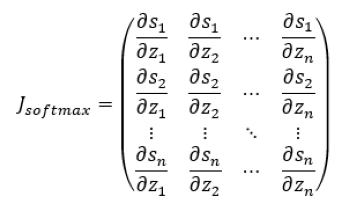

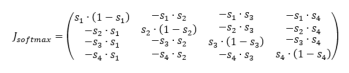

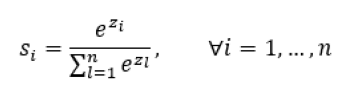

In [34]:
for i in range(1, 4):
    plt.axis('off')
    plt.imshow(Image.open(f'{i}.png'))
    plt.show()

In [35]:
a = np.array([[1, 2, -1, 4], [1, 2, -1, 4]]) # простой пример
a = a - np.max(a, axis=1)[:, np.newaxis]
softmax_output = np.exp(a)/np.sum(np.exp(a), axis=1)[:, np.newaxis]
softmax_output

array([[0.04177257, 0.11354962, 0.0056533 , 0.83902451],
       [0.04177257, 0.11354962, 0.0056533 , 0.83902451]])

In [7]:
stacked_probabilities1 = np.repeat(softmax_output[:, :, np.newaxis], softmax_output.shape[1], axis=2)
stacked_probabilities1

array([[[0.04177257, 0.04177257, 0.04177257, 0.04177257],
        [0.11354962, 0.11354962, 0.11354962, 0.11354962],
        [0.0056533 , 0.0056533 , 0.0056533 , 0.0056533 ],
        [0.83902451, 0.83902451, 0.83902451, 0.83902451]],

       [[0.04177257, 0.04177257, 0.04177257, 0.04177257],
        [0.11354962, 0.11354962, 0.11354962, 0.11354962],
        [0.0056533 , 0.0056533 , 0.0056533 , 0.0056533 ],
        [0.83902451, 0.83902451, 0.83902451, 0.83902451]]])

In [8]:
stacked_probabilities2 = np.transpose(stacked_probabilities1, axes=(0, 2, 1))
stacked_probabilities2

array([[[0.04177257, 0.11354962, 0.0056533 , 0.83902451],
        [0.04177257, 0.11354962, 0.0056533 , 0.83902451],
        [0.04177257, 0.11354962, 0.0056533 , 0.83902451],
        [0.04177257, 0.11354962, 0.0056533 , 0.83902451]],

       [[0.04177257, 0.11354962, 0.0056533 , 0.83902451],
        [0.04177257, 0.11354962, 0.0056533 , 0.83902451],
        [0.04177257, 0.11354962, 0.0056533 , 0.83902451],
        [0.04177257, 0.11354962, 0.0056533 , 0.83902451]]])

In [9]:
np.eye(4) - 1

array([[ 0., -1., -1., -1.],
       [-1.,  0., -1., -1.],
       [-1., -1.,  0., -1.],
       [-1., -1., -1.,  0.]])

Получим градиенты для элементов матрицы, не лежащих на главной диагонали:

In [17]:
nondiagonal_gradients = stacked_probabilities1 * stacked_probabilities2 * (np.eye(4) - 1)
nondiagonal_gradients

array([[[ 0.        , -0.00474326, -0.00023615, -0.03504821],
        [-0.00474326,  0.        , -0.00064193, -0.09527091],
        [-0.00023615, -0.00064193,  0.        , -0.00474326],
        [-0.03504821, -0.09527091, -0.00474326,  0.        ]],

       [[ 0.        , -0.00474326, -0.00023615, -0.03504821],
        [-0.00474326,  0.        , -0.00064193, -0.09527091],
        [-0.00023615, -0.00064193,  0.        , -0.00474326],
        [-0.03504821, -0.09527091, -0.00474326,  0.        ]]])

In [12]:
np.repeat(np.eye(4)[np.newaxis, :, :], 2, axis=0) 

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]])

Получим градиенты для элементов матрицы, лежащих на главной диагонали:

In [16]:
diagonal_gradients = np.repeat(np.eye(4)[np.newaxis, :, :], 2, axis=0) * (softmax_output * (1-softmax_output))[:, np.newaxis, :]
diagonal_gradients

array([[[0.04002762, 0.        , 0.        , 0.        ],
        [0.        , 0.1006561 , 0.        , 0.        ],
        [0.        , 0.        , 0.00562134, 0.        ],
        [0.        , 0.        , 0.        , 0.13506238]],

       [[0.04002762, 0.        , 0.        , 0.        ],
        [0.        , 0.1006561 , 0.        , 0.        ],
        [0.        , 0.        , 0.00562134, 0.        ],
        [0.        , 0.        , 0.        , 0.13506238]]])

In [18]:
jacobi = diagonal_gradients + nondiagonal_gradients
jacobi

array([[[ 0.04002762, -0.00474326, -0.00023615, -0.03504821],
        [-0.00474326,  0.1006561 , -0.00064193, -0.09527091],
        [-0.00023615, -0.00064193,  0.00562134, -0.00474326],
        [-0.03504821, -0.09527091, -0.00474326,  0.13506238]],

       [[ 0.04002762, -0.00474326, -0.00023615, -0.03504821],
        [-0.00474326,  0.1006561 , -0.00064193, -0.09527091],
        [-0.00023615, -0.00064193,  0.00562134, -0.00474326],
        [-0.03504821, -0.09527091, -0.00474326,  0.13506238]]])

In [84]:
class SoftMax(Module):
    def __init__(self):
         super().__init__()
    
    def forward(self, input):
        input -= np.max(input, axis=1)[:, np.newaxis]
        self.output = np.exp(input)/np.sum(np.exp(input), axis=1)[:, np.newaxis]
        return self.output
    
    def backward(self, input, grad_output):
        stacked_probabilities1 = np.repeat(self.output[:, :, np.newaxis], input.shape[1], axis=2)
        stacked_probabilities2 = np.transpose(stacked_probabilities1, axes=(0, 2, 1))
        diagonal_gradients = np.repeat(np.eye(input.shape[-1])[np.newaxis, :, :], input.shape[0], axis=0) * (self.output * (1-self.output))[:, np.newaxis, :]
        nondiagonal_gradients = stacked_probabilities1 * stacked_probabilities2 * ((np.eye(input.shape[-1]) - 1))
        Jacobi_matriсes = diagonal_gradients + nondiagonal_gradients # матрица частных производных
        grad_input = (grad_output[:, np.newaxis, :] @ Jacobi_matriсes)[:, 0, :]
        return grad_input

## Регуляризация

Самый популярный регуляризатор в нейросетях — [**дропаут**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). Идея простая: просто помножим поэлементно входные данные на случайную бинарную маску того же размера, как и сами данные. Сгенерировать маску можно через `np.random.binomial`.

Дропаута обычно хватает как единственного регуляризатора. Если вы заметите, что сеть оверфитится — просто добавьте его побольше.

**У дропаута разное поведение в режимах `train` и `eval`**. При `eval` он не должен делать ничего, а в `train` вместо применения маски нужно ещё домножить вход на $p$, чтобы скомпенсировать дропаут при обучении (так математическое ожидание значений будет такое же, как на трейне).

In [66]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super().__init__()
        
        self.p = p
        self.mask = None
        
    def forward(self, input):
        if self._train:
            self.mask = np.random.random(input.shape) > self.p
            self.output = input * self.mask
        else:
            self.output = input * (1 - self.p)
        return self.output
    
    def backward(self, input, grad_output):
        if self._train:
            grad_input = grad_output * self.mask
        else:
            grad_input = grad_output * (1 - self.p)
        return grad_input

`BatchNorm` -- относительно современный слой, сильно улучшающий сходимость. Всё, что он делает -- это нормирует свои входные значения так, что на выходе получаются значения со средним 0 и дисперсией 1.

<img width='300px' src='https://wiseodd.github.io/img/2016-07-04-batchnorm/00.png'>

Почитать про вывод градиента для него можно тут: https://wiseodd.github.io/techblog/2016/07/04/batchnorm/

BatchNorm тоже по-разному ведёт себя при обучении и инференсе. Во время инференса он использует в качестве оценки среднего и дисперсии свои экспоненциально усреднённые исторические значения. Это связано с тем, что батч может быть маленьким, и оценки среднего и дисперсии будут неточными (при батче размера 1 дисперсия вообще будет нулевая, и нам в алгоритме нужно будет делить на ноль).

In [53]:
class BatchNorm(Module):
    def __init__(self, xshape, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = np.ones(xshape)
        self.beta = np.zeros(xshape)
        self.mu_global = 0
        self.variance_global = 1
        self.inference_coef1 = None
        self.inference_coef2 = None
    
    def forward(self, input):
        if self._train:
            self.mu = np.mean(input, axis=0)
            self.variance = np.mean((self.mu - input)**2, axis=0)
            self.input = input
            self.x_hat = (input - self.mu)/np.sqrt(self.variance+self.eps)
            self.output = self.gamma*self.x_hat + self.beta
        else:
            if self.inference_coef1 is None: # посчитаем заранее, чтобы во время инференса быстро давать ответ
                self.inference_coef1 = self.gamma/np.sqrt(self.variance_global+self.eps) 
                self.inference_coef2 = self.beta - self.gamma*self.mu_global/np.sqrt(self.variance_global+self.eps)
            self.output = input * self.inference_coef1 + self.inference_coef2
        return self.output
    
    def backward(self, input, grad_output):
        if self._train:
            batch_size=input.shape[0]
            inversed_variance = 1 / np.sqrt(self.variance + self.eps) 
            self.grad_beta = np.sum(grad_output, axis=0)
            self.grad_gamma = grad_output*self.x_hat
            grad_input_hat = grad_output * self.gamma
            grad_variance =  -0.5 * (inversed_variance ** 3) * np.sum(grad_input_hat * (self.input-self.mu) , axis=0) 
            grad_mu = (-2 * grad_variance / batch_size) * np.sum(self.input-self.mu , axis=0) + np.sum(grad_input_hat*(-inversed_variance), axis=0)
            grad_input = (grad_mu / batch_size) + grad_variance*(2/batch_size)*(self.input-self.mu) + grad_input_hat*inversed_variance
            self.mu_global = self.mu_global*0.99 + 0.01*self.mu # exponential moving average
            self.variance_global = self.variance_global*0.99 + 0.01*self.variance
        else:
            pass
        return grad_input

    def parameters(self):
        return [self.gamma, self.beta]

    def grad_parameters(self):
        return [self.grad_gamma, self.grad_beta]

## Критерии

Критерии — это специальные функции, которые меряют качество, имея реальные данные и предсказанные. Все критерии возвращают скаляр — одно число, усреднённое значение метрики по всему батчу.

По сути это тоже модули, но мы всё равно создадим для них отдельный класс, потому что у них нет `train` / `eval`, а `backward` не требует `grad_output` — эта вершина и так конечная в вычислительном графе. Также нам не понадобится сохранять для них `output`.

In [51]:
class Criterion():        
    def forward(self, input, target):
        raise NotImplementedError

    def backward(self, input, target):
        raise NotImplementedError

В качестве примера реализуем среднюю квадратичную ошибку (`MSE`).

Обратите внимание, что в критериях мы делим итоговое число на размер батча — мы не хотим, чтобы функция потерь зависела от количества примеров.

In [68]:
class MSE(Criterion):
    def forward(self, input, target):
        batch_size = input.shape[0]
        self.output = np.sum(np.power(input - target, 2)) / batch_size
        return self.output
 
    def backward(self, input, target):
        self.grad_output  = (input - target) * 2 / input.shape[0]
        return self.grad_output

Ваша задача посложнее: вам нужно реализовать кроссэнтропию — это стандартная функция потерь для классификации. Тут можно почитать про вывод её градиентов, а также софтмакса: https://deepnotes.io/softmax-crossentropy

Напоминаем интуицию за принципом максимального правдоподобия: мы максимизируем произведение предсказанных вероятностей реально случившихся событий $ L = \prod p_i $.

Произведение оптимизировать не очень удобно, и поэтому мы возьмём логарифм (любой, ведь все логарифмы отличаются в константу раз) и будем вместо него максимизировать сумму:

$$ \log L = \log \prod p_i = \sum \log p_i $$

Эту штуку называют кроссэнтропией. Такое название пошло из теории информации, но нам пока знать это не надо.

Для удобноства вместо чисел — от 0 до 9 — будем использовать вектора размера 10, где будет стоять единица в нужном месте (такое кодирование называется one-hot).

In [52]:
class CrossEntropy(Criterion):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target): 
        input -= np.max(input, axis=1)[:, np.newaxis]
        self.probs = np.exp(input)/np.sum(np.exp(input), axis=1)[:, np.newaxis]
        return np.mean(-np.sum(target*np.log(self.probs), axis=1))

    def backward(self, input, target):
        return self.probs - target

In [ ]:
class NegativeLikelihood(Criterion):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target): 
        return np.mean(-np.sum(target*np.log(input), axis=1))

    def backward(self, input, target):
        return input - target